In [5]:
import import_ipynb

import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

from environment import TicTacToe3D
from qAgent import QAgent

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
  from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [7]:
env = TicTacToe3D(headless=True)
agent = QAgent(training=True, weight_path="./weights/qlearn.pth")

Complete


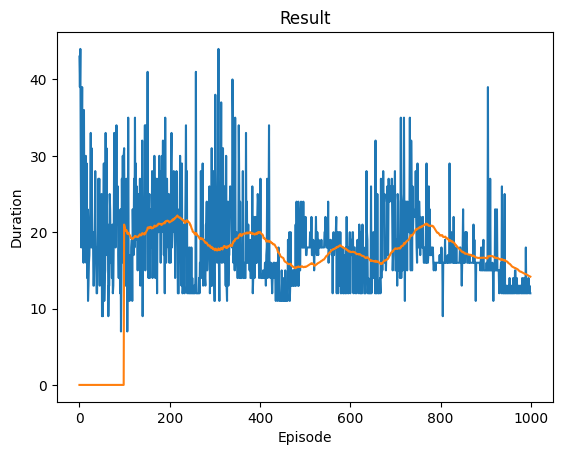

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
num_episodes = 1000

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, possible_move = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0).view(-1, 64)

    # print(state)

    player = 1

    for t in count():
        action = agent.findBestMove(board=state, possible_move=possible_move, player=player)

        if action == None:
            # terminated = draw
            reward = 0
            terminated = True
        else:
            act = action.item()

            # print(act)
            row = act // 4
            col = act % 4
            # print(f"{player} {row+1}, {col+1}")
            # terminated = lose
            movable, observation, possible_move, reward, terminated = env.move(row, col, player)

        reward = torch.tensor([reward], device=device)
        done = terminated or (action == None)

        player = -player

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0).view(-1, 64)

        # Store the transition in memory
        # action_remember = torch.zeros(16, dtype=torch.int64, device=device)
        # action_remember[action.item()] = 1
        agent.memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        agent.optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = agent.target_net.state_dict()
        policy_net_state_dict = agent.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*agent.TAU + target_net_state_dict[key]*(1-agent.TAU)
        agent.target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()